In [1]:
!python -m pip install seaborn numpy pandas tqdm gensim scikit-learn

  Using cached stellargraph-1.2.1-py3-none-any.whl (435 kB)
  Using cached chardet-5.2.0-py3-none-any.whl (199 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.4 MB/s eta 0:00:00a 0:00:01
  Using cached numpy-1.24.4-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached pandas-2.0.3-cp38-cp38-macosx_10_9_x86_64.whl (11.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 2.9 MB/s eta 0:00:00
  Using cached gensim-4.3.2-cp38-cp38-macosx_10_9_x86_64.whl (24.1 MB)
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (10.1 MB)
  Using cached tensorflow-2.13.1-cp38-cp38-macosx_10_15_x86_64.whl (216.2 MB)
  Using cached scipy-1.10.1-cp38-cp38-macosx_10_9_x86_64.whl (35.0 MB)
  Using cached matplotlib-3.7.5-cp38-cp38-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached smart_open-7.0.4

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from functools import reduce
import datetime
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from utils import * 
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter, BiasedRandomWalk, TemporalRandomWalk
from scipy.special import softmax
from tqdm import tqdm
import math
from sklearn.preprocessing import normalize
from math import isclose
import multiprocessing
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from TRW_nodesim import *


2024-04-28 13:59:10.846514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# CM_Time() & Weekly Graph Construction

In [2]:
class temporalNetwork(): 
    def __init__(self, start_date, end_date, display_progress=False, location_grouping='kma', origin=None, facility_id=None, intermediate=None):
        """ 
        Note: 
            start_date and end_date should be both None as they are used as a signal to 
            CM_Time's run_simulation to whether construct a new graph or update the graph with new information 
        """
        self.display_progress = display_progress
        self.start_date=start_date
        self.end_date=end_date
        self.network=None
        self.origin_location_list=None
        self.location_grouping=location_grouping
        self.inbound_data = None 
        self.outbound_data = None

    def construct_network_graph(self):
        """ 
        Given an inbound and outbound dataframe, construct a network graph and stores it in the class variable self.network
        Args: 
            an_inbound_df (pd.DataFrame): inbound dataframe
            an_outbound_df (pd.DataFrame): outbound dataframe
            start_date (datetime): start date of the network graph
            end_date (datetime): end date of the network graph
            location_grouping(string): 'kma' or 'zip3'
        """
        # pull data & construct an empty multiDiGraph

        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        an_inbound_df, an_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        an_inbound_df.load_date, an_outbound_df.load_date = pd.to_datetime(an_inbound_df.load_date), pd.to_datetime(an_outbound_df.load_date)
        for colin, colout in zip(an_inbound_df.columns, an_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                an_inbound_df[colin] = an_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                an_outbound_df[colout] = an_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, an_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, an_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, an_inbound_df, an_outbound_df, self.location_grouping)
        
        # update the variables 
        self.network = network_graph
        self.origin_location_list = an_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = an_inbound_df, an_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
        
    def move_to_next_week(self): 
        """ 
        Given the new week's inbound and outbound dataframes, 
        update self.network graph, self.start_date, and self.end_date to a week after current start date and end date 
        
        Args:
            next_inbound_df (pd.DataFrame): new week's inbound dataframe
            next_outbound_df (pd.DataFrame): new week's outbound dataframe
            display_progress (boolean): whether to display the progress of the function or not
        """
        # update the dates, pull new week's data, & store some informations
        self.start_date, self.end_date = self.start_date + timedelta(days=7), self.end_date + timedelta(days=7)
        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        next_inbound_df, next_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        next_inbound_df.load_date, next_outbound_df.load_date = pd.to_datetime(next_inbound_df.load_date), pd.to_datetime(next_outbound_df.load_date)
        for colin, colout in zip(next_inbound_df.columns, next_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                next_inbound_df[colin] = next_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                next_outbound_df[colout] = next_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"new network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, next_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, next_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, next_inbound_df, next_outbound_df, self.location_grouping)

         # update the variables 
        self.network = network_graph
        self.origin_location_list = next_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = next_inbound_df, next_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
       

    def print_network_information(self, given_network, print_network_time=False): 
        """
        Given a network, print out the information of the network
        Args: 
            given_network (nx.MultiDiGraph): a network graph
        Returns: N/A
        """
        print("---------------------------------------------------------------------------------------------") 
        print(given_network)
        print(f"Is the given network a DAG for load_network?: {nx.is_directed_acyclic_graph(given_network)}")
        print(f"Number of self loops: {nx.number_of_selfloops(given_network)}")
        if print_network_time: print(f"Current time of the graph: {given_network.graph['start_date']} to {given_network.graph['end_date']}")
        else: print(f"Current time of the graph: {self.start_date} to {self.end_date}")


In [3]:
class CM_Finder():
    def __init__(self, location_grouping='kma', origin_location_list=None, network = None):
        self.network=network
        self.processed_network=None
        self.processed=False 
        self.origin_location_list=origin_location_list
        self.match_failure = None
        self.remove_failure = 0
        self.location_grouping=location_grouping
        
    def group_to_DiGraph(self, display_progress = False):
        """
        #TODO: explain why aggregate_faciility_zip then group_to_DiGraph (kma-> facility_zip -> kma to kma->kma->kma, aggregate to faciliy KMA)
        Assuming that self.network is constructed, 
        sums the edge weights for edges with the same nodes in self.network variable and 
        stores the new graph with aggregated edges in self.processed_network variable and returns False if successful 

        Args:
            display_progress (boolean): whether to display the progress of the function or not

        NOTE) disregards temporal factor 
        """
        if not self.network: 
            print("Please construct the network first")
            return None 
            
        new_name = self.network.name + " reduced"
        self.processed_network = nx.DiGraph(name=new_name)
        self.processed_network.add_nodes_from(self.network)

        if display_progress: print("Aggregating nodes by KMA...")
        for n1, n2 in self.network.edges():
            sum = 0 
            for inner_dict in self.network.get_edge_data(n1, n2).values(): 
                sum += inner_dict['capacity']
            self.processed_network.add_edge(n1, n2, capacity = sum)
        
        nx.set_edge_attributes(self.processed_network, to_integer(self.network.graph['end_date']), 'time')
        self.processed = True

In [4]:
class CM_Time(): 
    def __init__(self, location_grouping='kma', origin=None, facility_id=None, intermediate=None): 
        self.start_date=None
        self.end_date=None
        self.cm_network = None   
        self.cm_finder = None
        self.origin=origin
        self.facility_id=facility_id
        self.intermediate=intermediate
        self.location_grouping = location_grouping
        self.weekly_graphs = {}
    
    def update_dates(self): 
        """
        Updates the start and end date by 7 days
        """ 
        self.start_date += timedelta(days=7)
        self.end_date += timedelta(days=7)

    def construct_or_update_tg(self, filter_key='load_count', display_progress=False, display_path_info=False):
        """ 
        Either (1) creates a network graph given a start and end date 
            or (2) updates the network graph to the next week's graph 

        Args: 
            start_date, end_date: start & end date of the first two weeks of the simulation

        Returns: n/a
        """        
        # construct or update cm_finder.network 
        if not self.cm_network: 
            self.cm_network = temporalNetwork(self.start_date, self.end_date, display_progress, self.location_grouping, self.origin, self.facility_id, self.intermediate)
            self.cm_network.construct_network_graph()
            self.cm_finder = CM_Finder(location_grouping=self.location_grouping)
        else: 
            self.cm_network.move_to_next_week()

        self.cm_finder.origin_location_list = self.cm_network.origin_location_list
        self.cm_finder.network = self.cm_network.network
        
        # self.cm_finder.group_to_DiGraph(display_progress = display_progress)
        self.weekly_graphs[self.end_date] = self.cm_finder.network

    def temporal_query(self, start_date, temporal=True, looback = 7, number_of_weeks=None, termination_date = None, \
                    filter_key = "load_count", display_progress=False, display_path_info = False): 
        """
        Given a start date, run the simulation for number_of_weeks or until termination_date is reached.

        Args: 
            start_date: start date of the first week of the simulation
            temporal: if True, run the simulation for every two weeks, if False, run the simulation from start_date until end_date
            number_of_weeks: number of weeks to run the simulation for
            termination_date: date to stop the simulation
            filter_key: key to filter the network on (load_count or path_score)
            display_progress: if True, display progress bar
            display_path_info: if True, display path info

        Returns: a dictionary of simulation result for each week
            
        Note:
        * termination_date: termination date of the entire analysis, when end_date reaches termination_date, the query loop terminates,
        * end_date: the end date of the two-week window, will be updated every week

        - Once the parameters (location_grouping, origin, facility_id, intermediate) are used to initialise the cm_time class, 
          they will be used for any further analysis until new initialisation happens.
          query_weekly method will only perform analysis, no alterations can be made by calling solely this.

        - If temporal=True, --> end_date != termination_date, eventually at the end of simulations, end_date = termination_date
            and number_of_weeks is given, end_date = start_date + 13 days for the first simulation, termination_date = start_date + 7 days * number_of_weeks
            and termination_date is given, end_date = start_date + 13 days for the first simulation and termination_date=termination_date for the simulation
          If temporal=False --> end_date = termination_date 
            and number_of_weeks is given, end_date = start_date + 7 days * number_of_weeks for the simulation 
            and termination_date is given, end_date=termination_date for the simulation

        * simulation_results: a dictionary with key as the end_date and value as the simulation result
        """

        # create information needed for a new query with the given start_date and number_of_weeks
        # possible bug when end_date > termination_date.
        if temporal: 
            self.start_date, self.end_date = start_date, start_date + timedelta(days=looback-1)

            if number_of_weeks: termination_date = self.start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: termination_date = termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
        
            # run simulation for every two weeks until termination_date
            while self.end_date <= termination_date:    
                self.construct_or_update_tg(filter_key=filter_key, \
                                    display_progress=display_progress, display_path_info=display_path_info)
                self.update_dates() 
                
        else: 
            if number_of_weeks: self.start_date, self.end_date = start_date, start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: self.start_date, self.end_date = start_date, termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
            self.run_single_simulation(filter_key=filter_key, \
                                display_progress=display_progress, display_path_info=display_path_info)

        return self.weekly_graphs

    def if_edge(node1, node2, curr_graph): 
        adjacency_matrix = curr_graph

In [5]:
# k1, k2 = list(weekly_graphs.keys())[:2]
# weekly_graphs[k1] == weekly_graphs[k2]

In [9]:
cm_time = CM_Time(location_grouping = 'kma') 
weekly_kma_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

In [10]:
cm_time = CM_Time(location_grouping = 'zip3') 
weekly_zip3_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

# Link Prediction Algorithm

In [40]:
def operator_div(u, v):
    return u / v

def operator_prod(u, v):
    return u * v
def operator_l2(u, v):
    return (u - v) ** 2
def operator_l1(u, v):
    return abs(u - v)
def operator_sub(u, v):
    return (u - v)

operators = [operator_prod, operator_l2, operator_l1, operator_sub]
operator_names = ["prod", "l2", "l1", "sub"]

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def all_edge_to_features(link_examples, transform_node):
    features_per_operator = {} 
    for operator,operator_name in zip(operators, operator_names): 
        features_per_operator[operator_name] = edge_to_features_given_operator(link_examples, transform_node, operator)
    return features_per_operator

def edge_to_features_given_operator(link_examples, transform_node, operator):
    return [
        operator(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]

def edge_to_features_given_operator_name(link_examples, transform_node, operator_name):
    operator = operators[operator_names.index(operator_name)]
    return edge_to_features_given_operator(link_examples, transform_node, operator)

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter, penalty="l2") #, solver="liblinear")
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


In [41]:
def temporal_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )
    
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def temporal_embedding(u):
        try:
            return temporal_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return temporal_embedding 

In [42]:
import numpy as np
import warnings
from collections import defaultdict, deque
from scipy import stats
from scipy.special import softmax
from stellargraph import StellarGraph
from stellargraph.core.schema import GraphSchema
from stellargraph.core.utils import is_real_iterable
from stellargraph.core.experimental import experimental
from stellargraph.random import random_state


class GraphWalk(object):
    """
    Base class for exploring graphs.
    """

    def __init__(self, graph, temporal=True, graph_schema=None, seed=None):
        self.graph = graph
        self.temporal=temporal

        # Initialize the random state
        self._check_seed(seed)

        self._random_state, self._np_random_state = random_state(seed)

        # We require a StellarGraph for this
        if not isinstance(graph, StellarGraph):
            raise TypeError("Graph must be a StellarGraph or StellarDiGraph.")

        if not graph_schema:
            self.graph_schema = self.graph.create_graph_schema()
        else:
            self.graph_schema = graph_schema

        if type(self.graph_schema) is not GraphSchema:
            self._raise_error(
                "The parameter graph_schema should be either None or of type GraphSchema."
            )

    def get_adjacency_types(self):
        # Allow additional info for heterogeneous graphs.
        adj = getattr(self, "adj_types", None)
        if not adj:
            # Create a dict of adjacency lists per edge type, for faster neighbour sampling from graph in SampledHeteroBFS:
            self.adj_types = adj = self.graph._adjacency_types(self.graph_schema)
        return adj

    def _check_seed(self, seed):
        if seed is not None:
            if type(seed) != int:
                self._raise_error(
                    "The random number generator seed value, seed, should be integer type or None."
                )
            if seed < 0:
                self._raise_error(
                    "The random number generator seed value, seed, should be non-negative integer or None."
                )

    def _get_random_state(self, seed):
        """
        Args:
            seed: The optional seed value for a given run.

        Returns:
            The random state as determined by the seed.
        """
        if seed is None:
            # Restore the random state
            return self._random_state
        # seed the random number generator
        rs, _ = random_state(seed)
        return rs

    def neighbors(self, node):
        if not self.graph.has_node(node):
            self._raise_error("node {} not in graph".format(node))
        return self.graph.neighbors(node)

    def run(self, *args, **kwargs):
        """
        To be overridden by subclasses. It is the main entry point for performing random walks on the given
        graph.

        It should return the sequences of nodes in each random walk.
        """
        raise NotImplementedError

    def _raise_error(self, msg):
        raise ValueError("({}) {}".format(type(self).__name__, msg))

    def _check_common_parameters(self, nodes, n, length, seed):
        """
        Checks that the parameter values are valid or raises ValueError exceptions with a message indicating the
        parameter (the first one encountered in the checks) with invalid value.

        Args:
            nodes: <list> A list of root node ids from which to commence the random walks.
            n: <int> Number of walks per node id.
            length: <int> Maximum length of each walk.
            seed: <int> Random number generator seed.
        """
        self._check_nodes(nodes)
        self._check_repetitions(n)
        self._check_length(length)
        self._check_seed(seed)

    def _check_nodes(self, nodes):
        if nodes is None:
            self._raise_error("A list of root node IDs was not provided.")
        if not is_real_iterable(nodes):
            self._raise_error("Nodes parameter should be an iterable of node IDs.")
        if (
            len(nodes) == 0
        ):  # this is not an error but maybe a warning should be printed to inform the caller
            warnings.warn(
                "No root node IDs given. An empty list will be returned as a result.",
                RuntimeWarning,
                stacklevel=3,
            )

    def _check_repetitions(self, n):
        if type(n) != int:
            self._raise_error(
                "The number of walks per root node, n, should be integer type."
            )
        if n <= 0:
            self._raise_error(
                "The number of walks per root node, n, should be a positive integer."
            )

    def _check_length(self, length):
        if type(length) != int:
            self._raise_error("The walk length, length, should be integer type.")
        if length <= 0:
            # Technically, length 0 should be okay, but by consensus is invalid.
            self._raise_error("The walk length, length, should be a positive integer.")

    # For neighbourhood sampling
    def _check_sizes(self, n_size):
        err_msg = "The neighbourhood size must be a list of non-negative integers."
        if not isinstance(n_size, list):
            self._raise_error(err_msg)
        if len(n_size) == 0:
            # Technically, length 0 should be okay, but by consensus it is invalid.
            self._raise_error("The neighbourhood size list should not be empty.")
        for d in n_size:
            if type(d) != int or d < 0:
                self._raise_error(err_msg)

def naive_weighted_choices(rs, weights):
    """
    Select an index at random, weighted by the iterator `weights` of
    arbitrary (non-negative) floats. That is, `x` will be returned
    with probability `weights[x]/sum(weights)`.

    For doing a single sample with arbitrary weights, this is much (5x
    or more) faster than numpy.random.choice, because the latter
    requires a lot of preprocessing (normalized probabilties), and
    does a lot of conversions/checks/preprocessing internally.
    """

    # divide the interval [0, sum(weights)) into len(weights)
    # subintervals [x_i, x_{i+1}), where the width x_{i+1} - x_i ==
    # weights[i]
    subinterval_ends = []
    running_total = 0
    for w in weights:
        if w < 0:
            raise ValueError("Detected negative weight: {}".format(w))
        running_total += w
        subinterval_ends.append(running_total)

    # pick a place in the overall interval
    x = rs.random() * running_total

    # find the subinterval that contains the place, by looking for the
    # first subinterval where the end is (strictly) after it
    for idx, end in enumerate(subinterval_ends):
        if x < end:
            break

    return idx

class NS_weighted_RandomWalk(GraphWalk):
    """
    Performs temporal random walks on the given graph. The graph should contain numerical edge
    weights that correspond to the time at which the edge was created. Exact units are not relevant
    for the algorithm, only the relative differences (e.g. seconds, days, etc).
    """
    def run(
        self,
        num_cw,
        cw_size,
        max_walk_length=80,
        initial_edge_bias=None,
        walk_bias=None,
        p_walk_success_threshold=0.01,
        seed=None,
    ):
        """
        Perform a time respecting random walk starting from randomly selected temporal edges.

        Args:
            num_cw (int): Total number of context windows to generate. For comparable
                results to most other random walks, this should be a multiple of the number
                of nodes in the graph.
            cw_size (int): Size of context window. Also used as the minimum walk length,
                since a walk must generate at least 1 context window for it to be useful.
            max_walk_length (int): Maximum length of each random walk. Should be greater
                than or equal to the context window size.
            initial_edge_bias (str, optional): Distribution to use when choosing a random
                initial temporal edge to start from. Available options are:

                * None (default) - The initial edge is picked from a uniform distribution.
                * "exponential" - Heavily biased towards more recent edges.

            walk_bias (str, optional): Distribution to use when choosing a random
                neighbour to walk through. Available options are:

                * None (default) - Neighbours are picked from a uniform distribution.
                * "exponential" - Exponentially decaying probability, resulting in a bias towards shorter time gaps.

            p_walk_success_threshold (float): Lower bound for the proportion of successful
                (i.e. longer than minimum length) walks. If the 95% percentile of the
                estimated proportion is less than the provided threshold, a RuntimeError
                will be raised. The default value of 0.01 means an error is raised if less than 1%
                of the attempted random walks are successful. This parameter exists to catch any
                potential situation where too many unsuccessful walks can cause an infinite or very
                slow loop.
            seed (int, optional): Random number generator seed; default is None.

        Returns:
            List of lists of node ids for each of the random walks.

        """
        if cw_size < 2:
            raise ValueError(
                f"cw_size: context window size should be greater than 1, found {cw_size}"
            )
        if max_walk_length < cw_size:
            raise ValueError(
                f"max_walk_length: maximum walk length should not be less than the context window size, found {max_walk_length}"
            )

        np_rs = self._np_random_state if seed is None else np.random.RandomState(seed)
        walks = []
        num_cw_curr = 0

        edges, times = self.graph.edges(include_edge_weight=True)
        edge_biases = self._temporal_biases(
            times, None, bias_type=initial_edge_bias, is_forward=False,
        )

        successes = 0
        failures = 0

        def not_progressing_enough():
            # Estimate the probability p of a walk being long enough; the 95% percentile is used to
            # be more stable with respect to randomness. This uses Beta(1, 1) as the prior, since
            # it's uniform on p
            posterior = stats.beta.ppf(0.95, 1 + successes, 1 + failures)
            return posterior < p_walk_success_threshold

        # loop runs until we have enough context windows in total
        while num_cw_curr < num_cw:
            first_edge_index = self._sample(len(edges), edge_biases, np_rs)
            src, dst = edges[first_edge_index]
            t = times[first_edge_index]

            remaining_length = num_cw - num_cw_curr + cw_size - 1

            walk = self._walk(
                src, dst, t, min(max_walk_length, remaining_length), walk_bias, np_rs
            )
            if len(walk) >= cw_size:
                walks.append(walk)
                num_cw_curr += len(walk) - cw_size + 1
                successes += 1
            else:
                failures += 1
                if not_progressing_enough():
                    raise RuntimeError(
                        f"Discarded {failures} walks out of {failures + successes}. "
                        "Too many temporal walks are being discarded for being too short. "
                        f"Consider using a smaller context window size (currently cw_size={cw_size})."
                    )

        return walks


    def _sample(self, n, biases, np_rs):
        if biases is not None:
            assert len(biases) == n
            return naive_weighted_choices(np_rs, biases)
        else:
            return np_rs.choice(n)

    def _exp_biases(self, times, t_0, decay):
        # t_0 assumed to be smaller than all time values
        return softmax(t_0 - np.array(times) if decay else np.array(times) - t_0)

    def _temporal_biases(self, times, time, bias_type, is_forward):
        if bias_type is None:
            # default to uniform random sampling
            return None

        # time is None indicates we should obtain the minimum available time for t_0
        t_0 = time if time is not None else min(times)

        if bias_type == "exponential":
            # exponential decay bias needs to be reversed if looking backwards in time
            return self._exp_biases(times, t_0, decay=is_forward)
        else:
            raise ValueError("Unsupported bias type")

    def _step(self, node, time, bias_type, np_rs):
        """
        Perform 1 temporal step from a node. Returns None if a dead-end is reached.

        """
        if self.temporal: 
            neighbours = [
                (neighbour, t)
                for neighbour, t in self.graph.neighbors(node, include_edge_weight=True)
                if t > time
            ]
        else: 
            neighbours = [
                (neighbour, t)
                for neighbour, t in self.graph.neighbors(node, include_edge_weight=True)
            ]
        
        def compute_jc(u_neighbours, v):
            # print(StellarGraph.neighbor_arrays(self.graph, v))
            v_neighbours = set(StellarGraph.neighbor_arrays(self.graph, v))
            union_size = len(u_neighbours.union(v_neighbours))
            if union_size == 0:
                return 0
            return len(u_neighbours.intersection(v_neighbours)) / union_size
        node_degrees = self.graph.node_degrees()

        if neighbours:
            times = [t for _, t in neighbours]
            biases = []
            node_degree = node_degrees[node]
            u_neighbours = set(StellarGraph.neighbor_arrays(self.graph, node))
            for ngh, t in neighbours: #G.neighbors(node):
                # print(ngh)
                pval=compute_jc(u_neighbours, ngh) + 1.0/node_degree
                biases.append(pval)
                 
            # biases = self._temporal_biases(times, time, bias_type, is_forward=True)
            if not len(biases): biases = None 
            # print(len(neighbours), )
            chosen_neighbour_index = self._sample(len(neighbours), biases, np_rs)
            next_node, next_time = neighbours[chosen_neighbour_index]
            return next_node, next_time
        else:
            return None

    def _walk(self, src, dst, t, length, bias_type, np_rs):
        walk = [src, dst]
        node, time = dst, t
        for _ in range(length - 2):
            result = self._step(node, time=time, bias_type=bias_type, np_rs=np_rs)

            if result is not None:
                node, time = result
                walk.append(node)
            else:
                break

        return walk


In [43]:
import numpy as np
import random

class nodesim_static_walk():
	def __init__(self, graph):
		print(graph)
		self.G = graph
		
	def nodesim_walk(self, walk_length, start_node):
		'''
		Simulate nodesim random walk starting from a given node.
		'''
		G = self.G
		probabilities=self.probabilities
		neighbors=self.neighbors
		walk = [start_node]
		while len(walk) < walk_length:
			cur = walk[-1]
			nextnode=random.choices(list(neighbors[cur]), list(probabilities[cur]))[0]
			walk.append(nextnode)
		return walk

	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly run random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print('Walk iteration:')
		for walk_iter in range(num_walks):
			print(str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.nodesim_walk(walk_length=walk_length, start_node=node))
		return walks

	def compute_edge_probs(self):
		'''
		Compute transition probabilities for nodesim random walks.
		'''

		def compute_jc(u_neighbours, v):
            # print(StellarGraph.neighbor_arrays(self.graph, v))
			v_neighbours = set(StellarGraph.neighbor_arrays(self.G, v))
			union_size = len(u_neighbours.union(v_neighbours))
			if union_size == 0: return 0
			return len(u_neighbours.intersection(v_neighbours)) / union_size

		G = self.G
		node_degrees = G.node_degrees()
		
		probs={}
		nghs={}
		node_degrees = G.node_degrees()
		for node in G.nodes():
			nghbrs=[]
			pr=[]
			node_degree = node_degrees[node]
			u_neighbours = set(StellarGraph.neighbor_arrays(G, node))
			for ngh in G.neighbors(node):
				nghbrs.append(ngh)
				pval=compute_jc(u_neighbours, ngh) + 1.0/node_degree
				pr.append(pval)
				
			s=sum(pr)
			pr=[x / s for x in pr]		
			probs[node]=pr
			nghs[node]=nghbrs
				
		self.probabilities=probs
		self.neighbors=nghs
		return 0

In [44]:
def data_split(graph, prediction_window_size=2, test_neg_size=None): 
    # identify first 5 & last 2 days' edges based on dates
    graph_with_negative_edges = graph.copy()
    graph = StellarGraph.from_networkx(graph, edge_weight_attr='time', edge_type_attr='directed')
    edges, weights = np.array(graph.edges(include_edge_weight=True)[0]), np.array(graph.edges(include_edge_weight=True)[1])
    lower_lim = sorted(list(set(weights)))[-prediction_window_size]
    index_test, index_train = np.where(weights >= lower_lim)[0], np.where(weights < lower_lim)[0]

    # create test & train edge sets
    test_pos_edges, test_time_labels = edges[index_test], weights[index_test]
    train_edges, train_time_labels = edges[index_train], weights[index_train]
    # test_pos_edges_with_time_attribute = np.rec.fromarrays([test_pos_edges[:,0], test_pos_edges[:,1], test_time_labels])
    train_edges_with_time_attribute = np.rec.fromarrays([train_edges[:,0], train_edges[:,1], train_time_labels])

    # create test and train graph 
    train_graph = nx.MultiDiGraph()
    train_graph.add_weighted_edges_from(train_edges_with_time_attribute,weight='time') 

    # create pos & neg edges for test graph 
    if not test_neg_size: 
        n = len(test_pos_edges) 
    else: 
        n = len(test_pos_edges) * test_neg_size
    test_neg_edges = list(nx.non_edges(train_graph)) #take the first x number of non edges
    test_pos_edges_tuple = [tuple(x) for x in test_pos_edges]
    test_neg_edges = np.array(list(set(test_neg_edges) - set(test_pos_edges_tuple)))[:n]
    test_edges = np.vstack((test_pos_edges, test_neg_edges))
    test_labels = np.hstack((np.ones(len(test_pos_edges)), np.zeros(len(test_neg_edges))))
    
    # to make sure there is no negative edge in the train graph that are in the test graph
    graph_with_negative_edges.add_edges_from(test_neg_edges)

    ## create train & validating edge sets from train graph 
    train_graph = StellarGraph.from_networkx(train_graph, edge_weight_attr='time', edge_type_attr='directed')
    edge_splitter_train = EdgeSplitter(train_graph, graph_with_negative_edges)
    graph_train, examples, labels = edge_splitter_train.train_test_split(
        p=0.1, method="global"
    )
    (
        examples_train,
        examples_validate, 
        labels_train,
        labels_validate
    ) = train_test_split(examples, labels, train_size=0.7, test_size=0.3)

    
    return test_edges, test_labels, graph_train, examples_train, labels_train, examples_validate, labels_validate

def random_walk_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2, nodesim=False, temporal=True): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    if temporal:
        if nodesim: 
            rw_model = NS_weighted_RandomWalk(graph)
        else:      
            rw_model = TemporalRandomWalk(graph)
        walks = rw_model.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
        )

    else: 
        if nodesim: 
            rw_model = NS_weighted_RandomWalk(graph, temporal=False)
            walks = rw_model.run(
            num_cw=num_cw,
            cw_size=context_window_size,
            max_walk_length=walk_length,
            walk_bias="exponential",
            )

        else: 
            rw_model = BiasedRandomWalk(graph)
            walks = rw_model.run(
            nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
            )
    
    embedding_size = 128
    node_embedding = Word2Vec(
        walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def get_node_embedding(u):
        try:
            return node_embedding.wv[u]
        except KeyError:
            return unseen_node_embedding
    return get_node_embedding 

In [71]:
from collections import defaultdict
class WeeklyDecisionMaker():
    def __init__(self, num_walks_per_node=10, walk_length = 10, context_window_size=2, expert_num=10, reward=False):
        # needed for temporal embedding
        self.num_walks_per_node = num_walks_per_node
        self.walk_length = walk_length
        self.context_window_size = context_window_size

        # weight optimization
        self.reward = reward
        self.naive_regret = 0
        self.past_naive_regrets = defaultdict(list)
        self.graph = None 
        self.expert_num = expert_num
        self.hedge_total_regret = [0]
        self.naive_total_regret = [0]

        # record purposes 
        self.test_edges = []
        self.test_edge_labels = []
        # self.curr_false_positive_set = set()
        self.train_validate_test_data = {}
        self.validation_scores = {'temporal': defaultdict(list), 'static': defaultdict(list), 'nodesim_temporal': defaultdict(list)}
        self.test_scores = defaultdict(list) #[]
        self.predicted_probs = [] 
        self.weight_vectors= defaultdict(list)

    def initialize_dictionaries(self, edge_tuple): 
        self.weight_vectors[edge_tuple] = [1/self.expert_num] * self.expert_num
    
    def fit_classifier(self, embeddings, labels):
        classifier = link_prediction_classifier()
        classifier.fit(embeddings, labels)
        return classifier

    def evaluate_score(self, clf, link_features, link_labels, threshold= 0.5, return_idces=False):
        self.predicted_probs = clf.predict_proba(link_features)
        positive_column = list(clf.classes_).index(1)
        if return_idces: 
            false_positive_idces = np.where((link_labels == 0) & (self.predicted_probs[:, positive_column] > threshold))[0]
            # true_positive_idces = np.where((link_labels == 1) & (predicted[:, positive_column] > 0.5))[0]
            return roc_auc_score(link_labels, self.predicted_probs[:, positive_column]), false_positive_idces #, true_positive_idces
        return roc_auc_score(link_labels, self.predicted_probs[:, positive_column])

    def update_curr_false_positive(self, new_edge_set, display_progress=False): 
        not_false_positive_anymore = self.curr_false_positive_set.intersection(new_edge_set)
        if display_progress: print(f"Not false positive anymore: {len(not_false_positive_anymore)}")
        if not_false_positive_anymore: 
            self.naive_regret -= len(not_false_positive_anymore)
            self.curr_false_positive_set = self.curr_false_positive_set - not_false_positive_anymore
            if display_progress: print(f"New Reduced Regret: {len(self.curr_false_positive_set)}")            

    def predict_probs(self, graph, display_progress=False, temporal=True): 
        # update regret by checking if they are in the new graph just given  
        # self.update_curr_false_positive(set(graph.edges()), display_progress=display_progress)

        # convert networkx graph to stellargraph & split data
        # graph = StellarGraph.from_networkx(graph, edge_weight_attr='time', edge_type_attr='directed')
        if display_progress: print("Splitting data...")
        links_test, labels_test, train_graph, links_train, labels_train, links_validate, labels_validate  = data_split(graph)
        self.train_validate_test_data[graph.graph['end_date']] = (links_train, labels_train, links_validate, labels_validate, links_test, labels_test)
        self.test_edges, self.test_edge_labels = links_test, labels_test

        # fit & learn 
        if display_progress: print("Computing node embeddings...")
        # nodesim_static_embedding = random_walk_model(train_graph,
        #                     num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
        #                     context_window_size=self.context_window_size, nodesim=True, temporal= False)
        # nodesim_temporal_embedding = random_walk_model(train_graph,
        #                     num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
        #                     context_window_size=self.context_window_size, nodesim=True, temporal= True)
        static_embedding = random_walk_model(train_graph,
                            num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
                            context_window_size=self.context_window_size, temporal= False)
        temporal_embedding = random_walk_model(train_graph, 
                            num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
                            context_window_size=self.context_window_size, temporal= True)
       
        # get edge embeddings for all edges
        if display_progress: print("Getting edge embeddings...")
        embedded_features = {'temporal': defaultdict(list), 'static': defaultdict(list)} #, 'nodesim_temporal': defaultdict(list), 'nodesim_static': defaultdict(list)}
        for links in [links_train, links_validate]:
            for operator,operator_name in zip(operators, operator_names): 
                temporal_edge_embedding = edge_to_features_given_operator(links, temporal_embedding, operator)
                static_edge_embedding = edge_to_features_given_operator(links, static_embedding, operator)
                # nodesim_temporal_edge_embedding = edge_to_features_given_operator(links, nodesim_temporal_embedding, operator)
                # nodesim_static_edge_embedding = edge_to_features_given_operator(links, nodesim_static_embedding, operator)
                embedded_features['temporal'][operator_name].append(temporal_edge_embedding)
                embedded_features['static'][operator_name].append(static_edge_embedding)
                # embedded_features['nodesim_temporal'][operator_name].append(nodesim_temporal_edge_embedding)
                # embedded_features['nodesim_static'][operator_name].append(nodesim_static_edge_embedding)
                
        # temporal_edge_embedding_train_per_operator = edge_to_features(links_validate, temporal_embedding)
        
        fitted_classifier_per_operator = {}
        
        for embedding_type in ['temporal', 'static']: 
            for operator_name in operator_names:
                if display_progress: print(f"Fitting classifiers & Evaluating scores ... for {operator_name} .. ")
                fitted_classifier_per_operator[operator_name] = self.fit_classifier(embedded_features[embedding_type][operator_name][0], labels_train) #fit classifier
                validation_score_per_operator = self.evaluate_score(fitted_classifier_per_operator[operator_name], embedded_features[embedding_type][operator_name][1], labels_validate)
                self.validation_scores[embedding_type][operator_name].append(validation_score_per_operator)
                if display_progress:  print(f"{embedding_type} Validation Score (ROC AUC): {validation_score_per_operator:.2f}")

            # choose the best classifier based on validation score
            if display_progress: print("Choosing the best classifier based on validation score ...")
            best_operator = operator_names[np.argmax([self.validation_scores[embedding_type][operator_name][-1] for operator_name in operator_names])]
            if display_progress: print(f"Best Operator: {best_operator}")

            # test the best classifier on test set
            test_embedding = None
            if embedding_type == 'temporal':
                test_embedding = edge_to_features_given_operator_name(links_test, temporal_embedding, best_operator)
            elif embedding_type == 'static':
                test_embedding = edge_to_features_given_operator_name(links_test, static_embedding, best_operator)
            elif embedding_type == 'nodesim_temporal':
                test_embedding = edge_to_features_given_operator_name(links_test, nodesim_temporal_embedding, best_operator)
            # else: 
            #     test_embedding = edge_to_features_given_operator_name(links_test, nodesim_static_embedding, best_operator)

            test_score = self.evaluate_score(fitted_classifier_per_operator[operator_name], test_embedding, labels_test)
            self.test_scores[embedding_type].append(test_score)
            if display_progress: 
                print(f"{embedding_type} Test Score (ROC AUC): {test_score:.2f}\n")
        
    def optimize_weights_for_edge(self, learning_rate=0.1, leader_thresholds = np.arange(0.1, 1.1, 0.1)): 
        self.hedge_total_regret.append(self.hedge_total_regret[-1])
        self.naive_total_regret.append(self.naive_total_regret[-1])

        # update regret for all test edges, keep track of weight vectors per edge 
        for edge_index, edge in enumerate(self.test_edges): 
            edge_tuple = tuple(edge)
            if edge_tuple not in self.weight_vectors.keys(): 
                self.initialize_dictionaries(edge_tuple)
            edge_existence = self.test_edge_labels[edge_index]
            edge_existence_prob = self.predicted_probs[edge_index,1] 
            self.hedge_per_edge(edge_tuple, edge_existence_prob, edge_existence, learning_rate, leader_thresholds)

    def hedge_per_edge(self, edge_tuple, edge_existence_prob, edge_existence, learning_rate = 0.1, leader_thresholds = np.arange(0.1, 1.1, 0.1)):
        wait_leaders = [1 if edge_existence_prob > threshold else 0 for threshold in leader_thresholds]
        not_wait_leaders = [1 if edge_existence_prob < threshold else 0 for threshold in leader_thresholds]
        weight_vector = self.weight_vectors[edge_tuple]

        # make decision based on each leader's recommendation & weight vector
        final_wait_decision = True if np.dot(wait_leaders, weight_vector) > np.dot(not_wait_leaders, weight_vector) else False 
        naive_decision = True if edge_existence_prob > 0.5 else False

        # record regret by checking if they are in the new graph & update weight 
        leader_made_wrong_decision = [1 if wait_decision != edge_existence  else 0 for wait_decision in wait_leaders]
        loss = 0
        if final_wait_decision != edge_existence:
            if final_wait_decision == 1: 
                loss = 3 #false positive treated most harshly 
            else: loss = 1 #false negative treated less harshly
        elif self.reward: 
            leader_made_wrong_decision = [-1 * wrong_decision for wrong_decision in leader_made_wrong_decision]
            if final_wait_decision == 1: 
                loss = -2 #true positive rewarded most  
            else: loss = -1 #true negative rewarded second most

        weight_vector = [weight_i * np.exp(-learning_rate * loss * wrong_decision) for wrong_decision, weight_i in zip(leader_made_wrong_decision, weight_vector)]        
        weight_vector = weight_vector/ np.sum(weight_vector) # renormalize weight_vector 
        self.weight_vectors[edge_tuple] = weight_vector
        self.hedge_total_regret[-1] += loss
        
        # update naive regret 
        curr_naive_loss = 0
        if naive_decision != edge_existence: 
            if final_wait_decision == 1: 
                curr_naive_loss = 3 #false positive treated most harshly 
            else: curr_naive_loss = 1 #false negative treated less harshly
        
        elif self.reward: 
            if naive_decision == 1: 
                curr_naive_loss = -2 #true positive rewarded most
            else: curr_naive_loss = -1 #true negative rewarded second most

        self.naive_total_regret[-1] += curr_naive_loss

    def run_expert_simulation(self, graph, learning_rate=0.1, temporal=True, display_progress=False):
        self.predict_probs(graph, display_progress=display_progress, temporal=temporal)
        self.optimize_weights_for_edge(learning_rate=learning_rate)
        if display_progress: self.print_info_given_week(graph.graph['end_date'])
        
    def print_info_given_week(self, curr_time): 
        print("--------------------------------------------------")
        print(f"Current Week: {curr_time}")
        # print(f"training error: {np.round(self.train_errors[-1],2)}, test error: {np.round(self.test_errors[-1],2)}")
        print(f"Total Number of Test Edges: {len(self.test_edges)}")
        print(f"Current Expert Regret: { self.hedge_total_regret[-1]}")
        print(f"Current Naive Regret: {self.naive_total_regret[-1]}")
        print("--------------------------------------------------")

    def graph_train_test_errors(self, time_range, graph_errors = True, graph_regret = False, title=None): 
        n = min(len(self.train_errors), len(self.test_errors))
        if title: plt.title(title)
        if graph_errors: 
            # plt.plot(time_range[:n], self.train_errors[:n], label='train')
            plt.plot(time_range[:n], self.test_errors[:n], label='test')
        if graph_regret: 
            plt.plot(time_range[:n], self.curr_regret[:n], label='regret')
        plt.legend() 
        plt.tight_layout()
        plt.show()


In [ ]:
zip3_comparison = WeeklyDecisionMaker(reward=False)
for graph in tqdm(weekly_zip3_graphs.values()):
    zip3_comparison.predict_probs(graph, display_progress=True)

1. given a route, are we doing this? 
2. or are we doing this for the entire graph? 

Since we are making the prediction on all potential edges for a graph, how would we do this..?

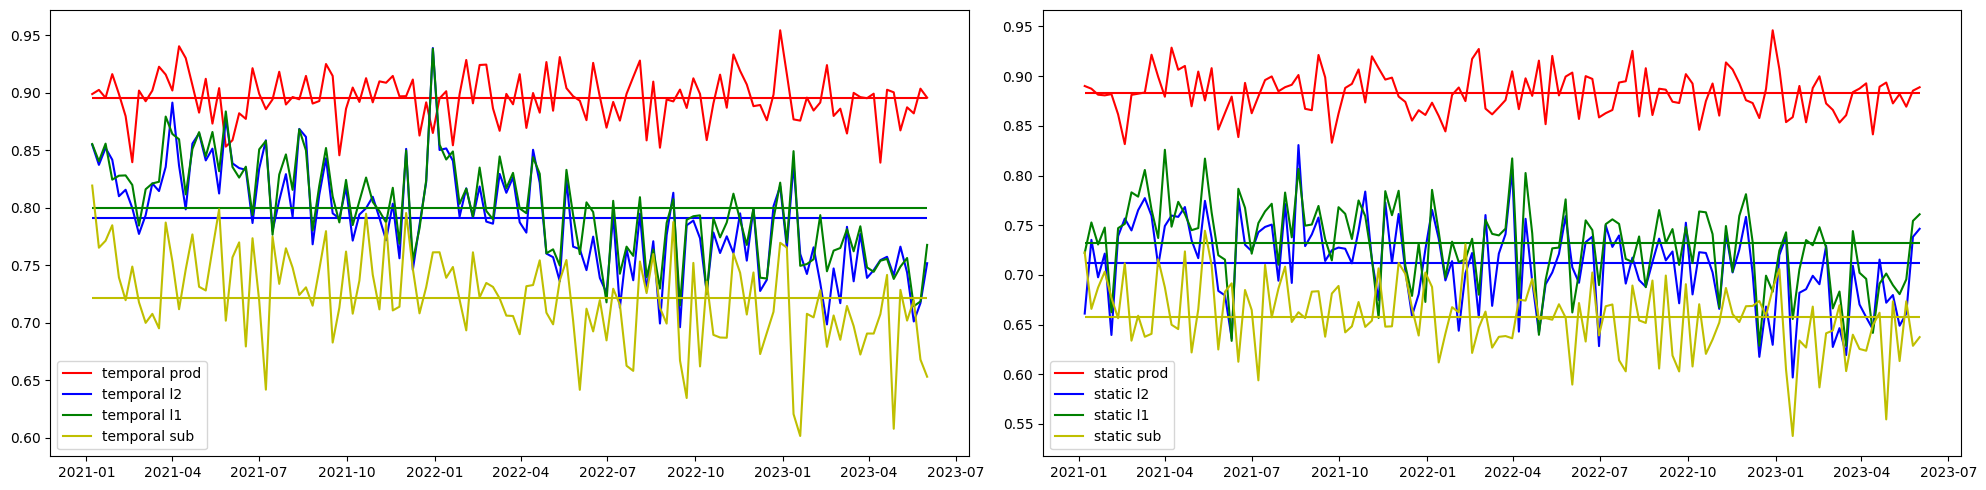

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
n = len(zip3_comparison.test_scores['temporal'])
time_range = list(weekly_kma_graphs.keys())[:n]
operator_colors = {'prod': 'r', 'l2': 'b', 'l1': 'g', 'sub': 'y'}
for operator_name in operator_names: 
    ax[0].plot(time_range, zip3_comparison.validation_scores['temporal'][operator_name], label='temporal ' + operator_name, color=operator_colors[operator_name])
    ax[1].plot(time_range, zip3_comparison.validation_scores['static'][operator_name], label='static ' + operator_name, color=operator_colors[operator_name])
    ax[0].hlines(np.mean(zip3_comparison.validation_scores['temporal'][operator_name]), time_range[0], time_range[-1], color=operator_colors[operator_name])
    ax[1].hlines(np.mean(zip3_comparison.validation_scores['static'][operator_name]), time_range[0], time_range[-1], color=operator_colors[operator_name])
    ax[0].legend()
    ax[1].legend()
fig.tight_layout()

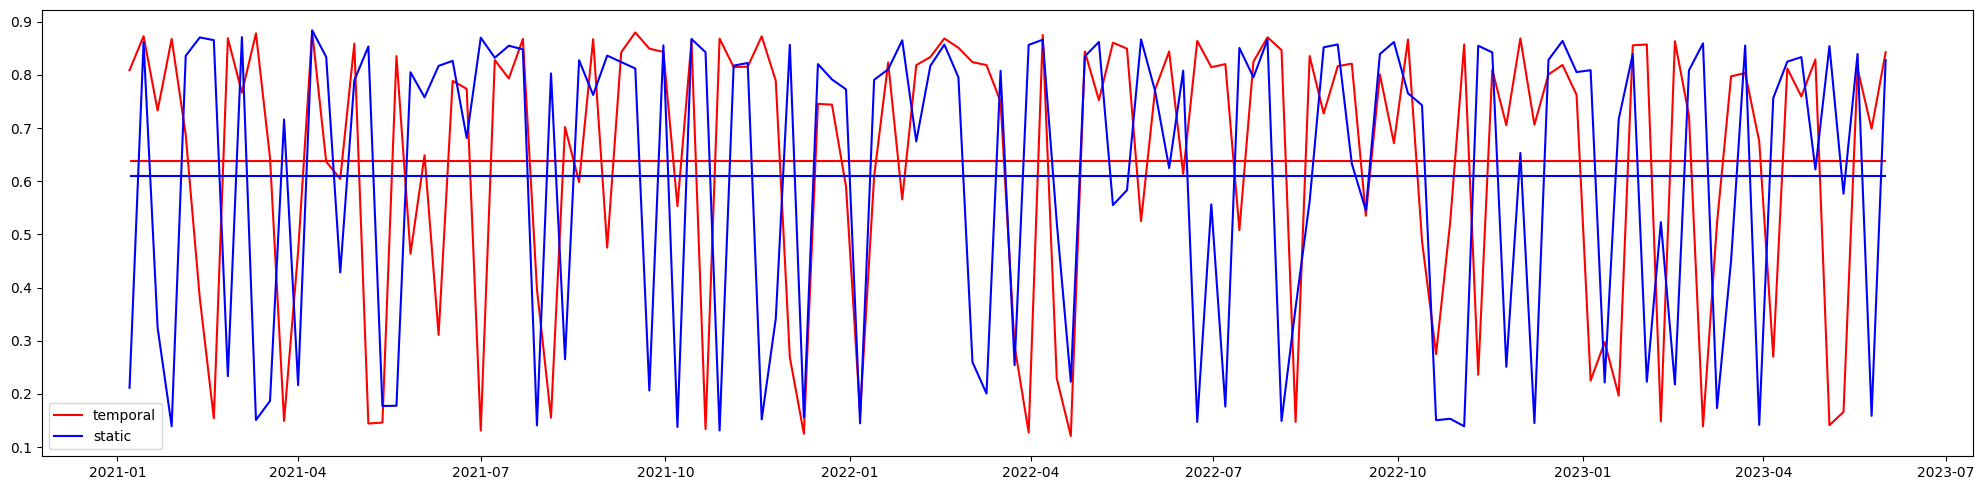

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
n = len(zip3_comparison.test_scores['temporal'])
algorithm_colors = {'temporal': 'r', 'static': 'b', 'nodesim_temporal': 'g'}
time_range = list(weekly_kma_graphs.keys())[:n]
for algorithm_type in ['temporal', 'static']:
    ax.plot(time_range, zip3_comparison.test_scores[algorithm_type], label=algorithm_type, color=algorithm_colors[algorithm_type])
    ax.hlines(np.mean(zip3_comparison.test_scores[algorithm_type]), time_range[0], time_range[-1], color=algorithm_colors[algorithm_type])
    ax.legend()
fig.tight_layout()

In [50]:
# sg_graph = StellarGraph.from_networkx(graph, edge_weight_attr='time', edge_type_attr='directed')
# [ngh for ngh, t in sg_graph.neighbors('561', include_edge_weight=True) if t > 20211108]

In [51]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# n = len(zip3_comparison.test_scores['temporal'])
# time_range = list(weekly_zip3_graphs.keys())[:n]
# for operator_name in operator_names: 
#     ax[0].plot(time_range, zip3_comparison.validation_scores['temporal'][operator_name], label='temporal ' + operator_name)
#     ax[1].plot(time_range[:-1], zip3_comparison.validation_scores['static'][operator_name][:44], label='static ' + operator_name)
#     # ax.plot(time_range[:-1], zip3_comparison.test_scores['static'], label='static ' + operator_name)
# # ax.hlines(np.mean(zip3_comparison.test_scores['temporal']), time_range[0], time_range[-1], label='temporal av', color='r')
# # ax.plot(time_range[:-1], zip3_comparison.test_scores['static'], label='static')
# # ax.hlines(np.mean(zip3_comparison.test_scores['static']), time_range[0], time_range[-1], label='static av', color='b')

# ax[0].legend()
# ax[1].legend()
# fig.tight_layout()

In [ ]:
# results = pd.read_csv("results/temporal_zip3_dm_result.csv")
# hedge_results, naive_results = list(results['hedge']), list(results['naive'])

In [ ]:
kma_comparison = WeeklyDecisionMaker(reward=False)
for graph in tqdm(weekly_kma_graphs.values()):
    kma_comparison.predict_probs(graph, display_progress=True)

# fig, ax = plt.subplots(1,1, figsize= (10, 5))
# fig.suptitle("Regret Comparison of Static Random Walk based Decision Maker on KMA data")
# ax.plot(weekly_zip3_graphs.keys(), static_kma_dm.hedge_total_regret[1:], label='hedge')
# ax.plot(weekly_zip3_graphs.keys(), static_kma_dm.naive_total_regret[1:], label='naive')
# ax.legend()
# ax.set_xlabel("Week")
# ax.set_ylabel("Regret")
# fig.tight_layout()

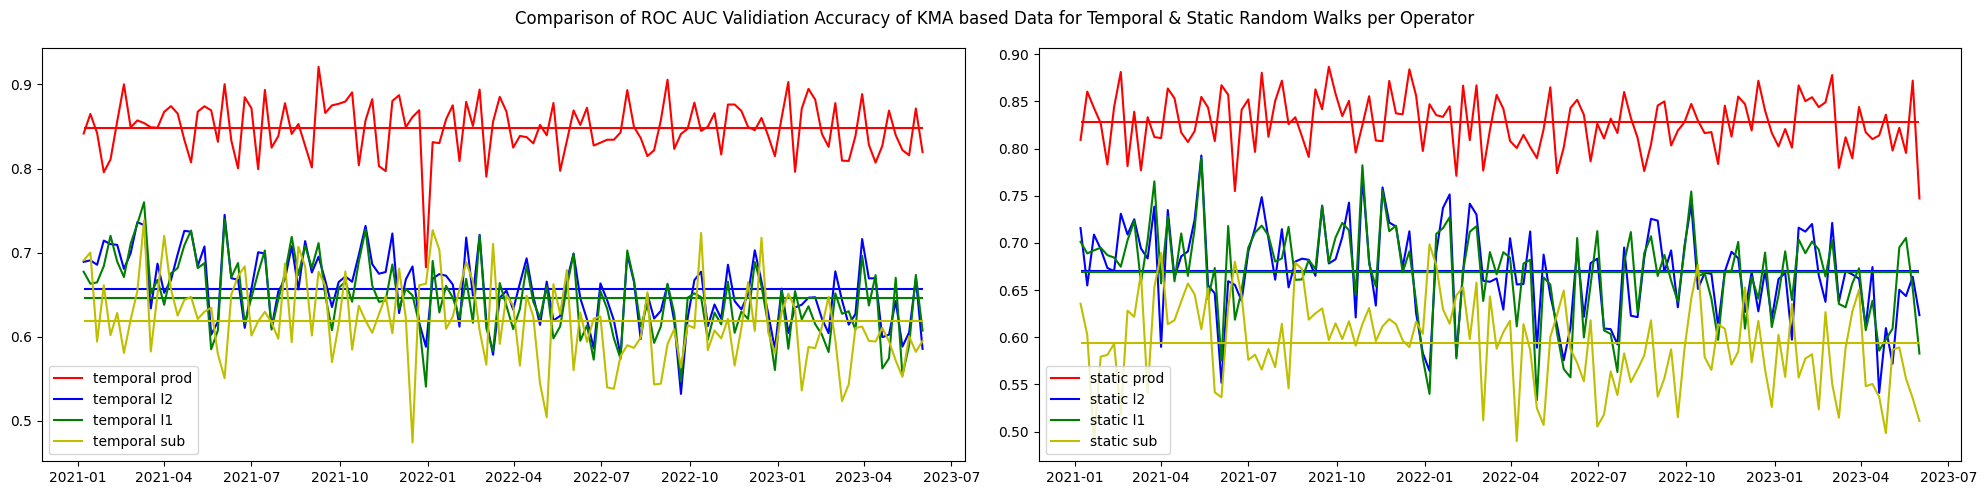

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
n = len(kma_comparison.test_scores['temporal'])
time_range = list(weekly_kma_graphs.keys())[:n]
operator_colors = {'prod': 'r', 'l2': 'b', 'l1': 'g', 'sub': 'y'}
for operator_name in operator_names: 
    ax[0].plot(time_range, kma_comparison.validation_scores['temporal'][operator_name], label='temporal ' + operator_name, color=operator_colors[operator_name])
    ax[1].plot(time_range, kma_comparison.validation_scores['static'][operator_name], label='static ' + operator_name, color=operator_colors[operator_name])
    # ax[2].plot(time_range, kma_comparison.validation_scores['nodesim_temporal'][operator_name], label='nodesim temporal ' + operator_name, color=operator_colors[operator_name])
    # ax.plot(time_range[:-1], zip3_comparison.test_scores['static'], label='static ' + operator_name)
    ax[0].hlines(np.mean(kma_comparison.validation_scores['temporal'][operator_name]), time_range[0], time_range[-1], color=operator_colors[operator_name])
    ax[1].hlines(np.mean(kma_comparison.validation_scores['static'][operator_name]), time_range[0], time_range[-1], color=operator_colors[operator_name])
    # ax[2].hlines(np.mean(kma_comparison.validation_scores['nodesim_temporal'][operator_name]), time_range[0], time_range[-1], color=operator_colors[operator_name])
    ax[0].legend()
    ax[1].legend()
    ax
    # ax[2].legend()
fig.suptitle("Comparison of ROC AUC Validiation Accuracy of KMA based Data for Temporal & Static Random Walks per Operator")
fig.tight_layout()

In [1]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
n = len(kma_comparison.test_scores['temporal'])
algorithm_colors = {'temporal': 'r', 'static': 'b', 'nodesim_temporal': 'g'}
time_range = list(weekly_kma_graphs.keys())[:n]
for algorithm_type in ['temporal', 'static']:
    ax.plot(time_range, kma_comparison.test_scores[algorithm_type], label=algorithm_type, color=algorithm_colors[algorithm_type])
    ax.hlines(np.mean(kma_comparison.test_scores[algorithm_type]), time_range[0], time_range[-1], color=algorithm_colors[algorithm_type])
    ax.legend()
ax.set_title("Comparison of ROC AUC Test Accuracy of KMA based Data for Temporal, Static, and Node Similarity + Temporal Random Walks")
fig.tight_layout()

NameError: name 'plt' is not defined

In [68]:
results = pd.DataFrame(kma_comparison.test_scores)
results.to_csv("results/kma_dm_result.csv", index=False)